In [1]:
using Revise
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
using Flux
using FluxOptTools
import ProgressMeter

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1317
┌ Info: Precompiling SIMDDualNumbers [3cdde19b-5bb0-4aaf-8931-af3e248e098b]
└ @ Base loading.jl:1317
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1317
┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1317
┌ Info: Precompiling FluxOptTools [ca11d760-9bce-11e9-0b7e-4f72fcadb4f9]
└ @ Base loading.jl:1317


In [2]:
data_seed, params_seed = 42, 120

(42, 120)

In [3]:
import ReactiveMP.messageout

In [4]:
include("helpers/data.jl")
include("helpers/form_constraint.jl")

In [6]:
function NN(y_,u_,θ)
    W1, b1 = reshape(θ[1:10],(5,2)), θ[11:15]
    W2, b2 = θ[16:20], θ[end]
    x = tanh.(W1*[y_;u_] .+ b1)
    W2'x + b2
end

melu(x) = clamp(x, tiny, Inf)

melu (generic function with 1 method)

In [8]:
NN_flux = Chain(Dense(2, 5, tanh),
                Dense(5, 1))
flux_nrparam(model) = sum(length(p) for p in Flux.params(model));

In [9]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max(n, model_flow::FlowModel, params, h_prior, y_prev, u)
    
    dim = length(h_prior[1])

    # Extract parameters for flow, neural network and Gamma
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end-2] # TODO: fix
    params_w = params[end-1:end]
    
    # initialize variables
    h       = randomvar(n)
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))}  
    w       = randomvar() where {form_constraint = FixedMarginalConstraint(GammaShapeRate(melu(params_w[1]), melu(params_w[2])))}
    y       = datavar(Float64, n)

    ar_nodes = Vector{FactorNode}(undef, n)
    y_nodes = Vector{FactorNode}(undef, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    y_lat_3 = randomvar(n)
    
    neural_out = [NN(y_prev[i], u[i], params_f) for i in 1:n] #TODO: fix

    # create meta for AR
    AR_meta = ARMeta(Multivariate, dim, ARsafe())
    # create meta compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])

    θ   ~ MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim))
    w   ~ GammaShapeRate(melu(params_w[1]), melu(params_w[2]))
    
    h_prev = h_0
    for t in 1:n
        # specify latent state
        ar_nodes[t], h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
        y_lat_1[t] ~ Flow(h[t]) where { meta = Flow_meta}
        y_lat_2[t] ~ dot(y_lat_1[t], ones(dim))
        y_lat_3[t] ~ y_lat_2[t] + neural_out[t]
        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_3[t], w)
        h_prev = h[t]
    end

    return h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_nodes
end

nonlinear_max (generic function with 1 method)

In [10]:
function nonlinear_max_inference(observations,observations_prev, controls, model_flow::FlowModel, params; 
                                 h_prior=(zeros(2), 0.1*diageye(2)), vmp_its=10)
    # fetch number of samples
    n = length(observations)

    # define model
    model, (h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_nodes) = nonlinear_max(n, model_flow, params, h_prior,
                                                                            observations_prev, controls,
                                                                            options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    θ_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    w_buffer = nothing
    
    h_sub = subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)
    θ_sub = subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))

    setmarginal!(w, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(dim), diageye(dim)))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # unsubscribe
    unsubscribe!(fe_sub)
    unsubscribe!(h_sub)
    unsubscribe!(w_sub)
    unsubscribe!(θ_sub)
    
    # return the marginal values
    return fe_buffer, h_buffer, w_buffer, y_out_buffer, θ_buffer
    
end

nonlinear_max_inference (generic function with 1 method)

In [11]:
# specify flow model
dim = 2
model_flow = FlowModel(dim,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

In [12]:
Random.seed!(data_seed)

n_samples = 1000
u = 3 .* sin.(collect(1:n_samples+10))
order_y, order_u, order_e = 1, 1, 1
y_lat, y_obs, h_gen = generate_data(n_samples, narx, Dict(:order_y=>order_y, :order_u=>order_u, :order_e=>order_e),
                                                     Dict(:er_var=>1e-2, :u=>u));

In [13]:
observations_prev = y_obs[1:end-1]
observations      = y_obs[2:end];
controls          = u[order_u:end];

In [14]:
train_size = 800
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

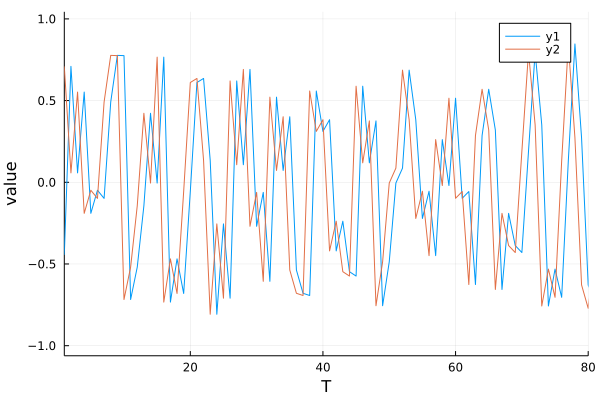

In [15]:
from, to = 1, 80
plot(X_train, xlims=(1, train_size))
plot!(Y_train, xlims=(from, to), xlabel="T", ylabel="value")

In [213]:
Random.seed!(params_seed)

flow_param_len = nr_params(model_flow)
NN_param_len = 21
model_params = [randn(flow_param_len+NN_param_len); [0.1, 1.0]]; #Flow, NN, Gamma

In [214]:
fe, h, w, y_out, θ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, model_params, vmp_its=10);

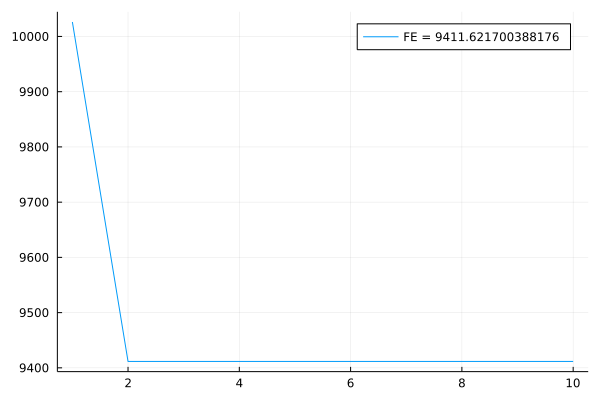

In [215]:
gr()
plot(fe, label="FE = $(fe[end])")

In [216]:
# Optimization function
function FE(params)
    fe, h, w, y_out, θ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, params, 
                                                 h_prior=(zeros(2), 0.1*diageye(2)), 
                                                 vmp_its=1)
    return fe[end]
end;

In [217]:
FE(model_params)

10026.176383688318

In [218]:
# unpack if you don't want to run Optim
@unpack inf_params = JLD.load("dump/dataseed_$(data_seed)_paramsseed_$(params_seed).jld")

Dict{String, Any} with 1 entry:
  "inf_params" => [-0.919459, 1.01178, -0.00865627, -1.70616, -0.382409, 1.1429…

In [221]:
using Optim
res = optimize(FE, model_params, GradientDescent(), Optim.Options(g_tol = 1e-12, iterations = 1000, store_trace = true, show_trace = true, show_every=10), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     1.002617e+04     8.048430e+04
 * time: 0.00014019012451171875
    10     5.433053e+02     3.219308e+02
 * time: 26.606377124786377
    20     3.233804e+02     2.115307e+02
 * time: 45.8306610584259
    30     2.265353e+02     1.138111e+02
 * time: 66.3696391582489
    40     1.917675e+02     7.180907e+01
 * time: 86.3436951637268
    50     1.704685e+02     5.928481e+01
 * time: 109.02679896354675
    60     1.544901e+02     6.048160e+01
 * time: 133.20959305763245
    70     1.414724e+02     6.057395e+01
 * time: 157.25224113464355
    80     1.304471e+02     5.945975e+01
 * time: 180.74427008628845
    90     1.208524e+02     5.698180e+01
 * time: 204.36432218551636
   100     1.122811e+02     5.281342e+01
 * time: 227.9597179889679
   110     1.045341e+02     4.703834e+01
 * time: 251.42012310028076
   120     9.748864e+01     4.073247e+01
 * time: 275.28131914138794
   130     9.106996e+01     4.252196e+01
 * time: 298.98271203041

 * Status: success

 * Candidate solution
    Final objective value:     5.251839e+01

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.91e+02 ≰ 1.0e-12

 * Work counters
    Seconds run:   880  (vs limit Inf)
    Iterations:    201
    f(x) calls:    1105
    ∇f(x) calls:   1105


In [222]:
inf_params = Optim.minimizer(res)


32-element Vector{Float64}:
 -0.5223302403038804
 -0.17688957142030695
 -0.3410055259812636
 -1.85454180659727
  0.7663637433061475
  1.5643672940813382
  1.9807056038820687
 -1.6007619957347778
  0.48167828787437944
 -0.28707234237309764
 -0.7050411823635827
  0.19728738197667672
  1.5476029068566495
  ⋮
 -0.7378331420649455
  0.5978454600859067
  2.050536606912865
 -1.2263622659981888
 -0.8065206047154585
  0.5849928582528823
  0.7211116616046208
  0.37289543979935674
 -0.4449964157461209
  0.10052316148711946
  3.7196438116070665
  0.34058132726210394

In [223]:
using JLD
JLD.save("dump/dataseed_$(data_seed)_paramsseed_$(params_seed).jld", "inf_params", inf_params)

In [224]:
FE(inf_params)

52.518386246771115

In [225]:
inf_params = Optim.minimizer(res)
fe_inf, h_inf, w_inf, y_out_inf, θ_inf = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, inf_params, vmp_its=100);

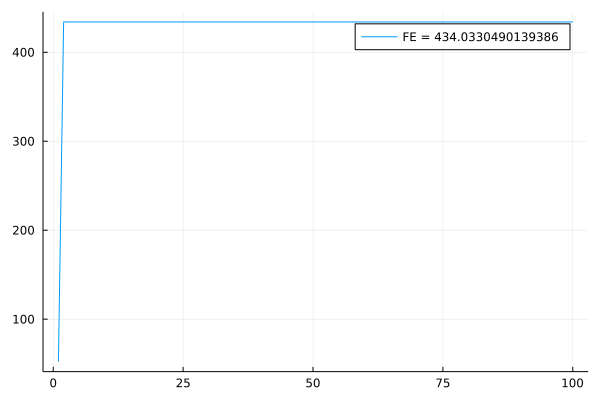

In [226]:
plot(fe_inf[1:end], label="FE = $(fe_inf[end])")

In [227]:
from, to = 100, 150

(100, 150)

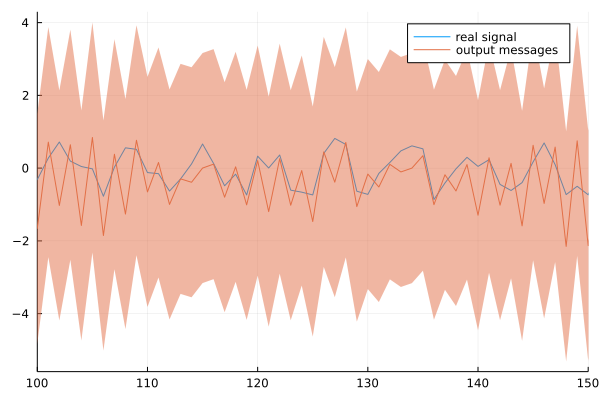

In [228]:
my, vy = mean.(y_out), cov.(y_out)
plot(Y_train, xlims=(from, to), label="real signal")
plot!(my, ribbon=sqrt.(vy), label="output messages")

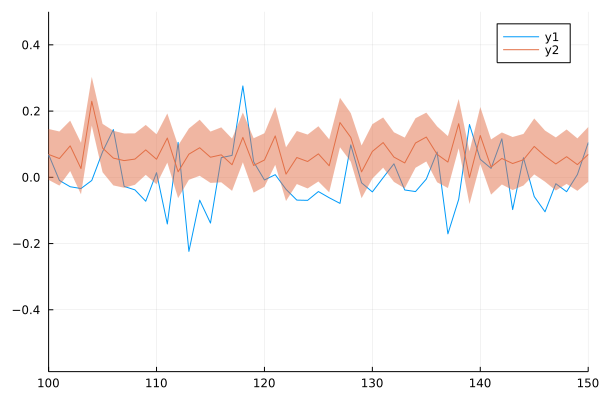

In [229]:
mh, vh = mean.(h_inf), cov.(h_inf)
plot(h_gen)
plot!(first.(mh), ribbon=sqrt.(first.(vh)), xlims=(from, to))

### KF-like prediction

In [230]:
function transition(γ, order)
    V = zeros(order, order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [231]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction(model_flow::FlowModel, params, w, h_prior, y_prev, u)
    
    dim = length(h_prior[1])

    A = shift(dim) # transition matrix
    V = transition(w, dim)

    # initialize variables
    y_pred   = datavar(Float64)
    
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end-2]
    params_w = params[end-1:end]

    h_0 = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(h_prior[1], h_prior[2]))}

    NN_pred = NN(y_prev, u, params_f)

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    
    Ah ~ A*h_0
    h ~ MvNormalMeanCovariance(Ah, V) where {q = q(Ah, h)q(V)}
    
    y_lat_1 ~ Flow(h) where { meta = Flow_meta, q = FullFactorisation() }
    
    y_lat_2 ~ dot(y_lat_1, ones(dim))
    
    y_lat_3 ~ y_lat_2 + NN_pred

    y_node, y ~ NormalMeanPrecision(y_lat_3, w) where { q = q(y, y_lat_3)q(w)}
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, h_0, y_lat_1, y_lat_2, y_lat_3, y, y_node, y_pred
end

nonlinear_max_prediction (generic function with 2 methods)

In [232]:
function nonlinear_max_prediction(observation_prev::T, control::T, model_flow::FlowModel, params; 
                                  h_prior=(ones(2), diageye(2)), w=1.0, vmp_its = 50) where T<:Float64

    # define model
    model, (h, h_0, y_lat_1, y_lat_2, y_lat_3, y, y_node, y_pred) = nonlinear_max_prediction(model_flow, params, w, h_prior,
                                                                                                    observation_prev, control,
                                                                                                    options = (limit_stack_depth = 500, ))
    
    h_buffer = nothing
    h0_buffer = nothing
    y_out_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    h0_sub = subscribe!(getmarginal(h_0), (x) -> h0_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y), (x) -> y_pred_buffer = x)

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, h0_buffer, y_pred_buffer
    
end

nonlinear_max_prediction (generic function with 2 methods)

In [250]:
predictions = []
h_prev = (mean(h_inf[end]), precision(h_inf[end]))
ŵ = mean(w_inf)
for i in 1:length(X_test)
    fe, h, h_0, y_pred = nonlinear_max_prediction(X_test[i], U_test[i], model_flow, inf_params, h_prior=h_prev, w=ŵ, vmp_its=10)
    push!(predictions, y_pred)
    _, h_inf, _, _, _ = nonlinear_max_inference([Y_test[i]], [X_test[i]], [U_test[i]], model_flow, inf_params, h_prior=h_prev, vmp_its=10);
    h_prev = (mean.(h_inf)[1], precision.(h_inf)[1])
end

In [251]:
w_pred = mean(w)

0.1

In [252]:
mx, vx = mean.(predictions), cov.(predictions)

([0.18243788981467343, -0.3639336546022325, -0.6768233597239434, -0.538858943350651, 0.3664634659209885, 0.19092622819410213, 0.5281207535592611, -0.5975380129310611, -0.5586496183123708, -0.5103650357781624  …  -0.6487457793735798, -0.46525289236076595, 0.21717134861989262, 0.24977587630932932, 0.3830039606693461, -0.5060229695479943, -0.6611200726890067, -0.03506383306190647, -0.7220767222154126, 0.5847470273267253], [2.2693814989469674, 2.278713915336388, 2.2568715846987546, 2.2674883873036116, 2.279943871706367, 2.2536553676652, 2.286465114789071, 2.2638170428958078, 2.272295155025169, 2.2683619979700724  …  2.257144677323635, 2.280905608688053, 2.2503752386194495, 2.2615069634479323, 2.275361574977259, 2.2732861882772952, 2.2575301395091985, 2.289918887506651, 2.218648418834355, 2.3015746454637593])

In [255]:
test_from, test_to = 150, 200

(150, 200)

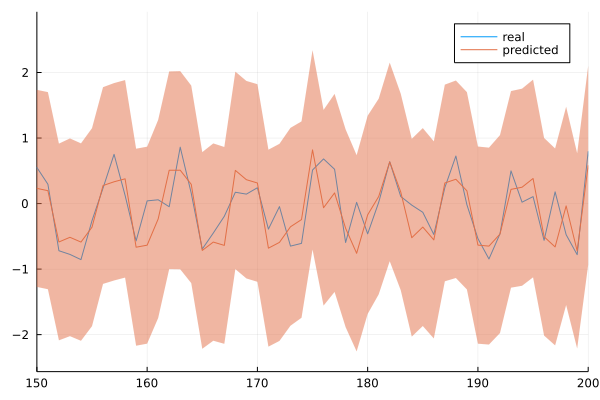

In [256]:
plot(Y_test, label="real")
plot!(mx, ribbon=sqrt.(vx), xlims=(test_from, test_to), label="predicted")

In [257]:
n_output = [NN(y_prev, u, inf_params[13:end]) for (y_prev, u) in zip(X_test, U_test)]

200-element Vector{Float64}:
  3.3491436358203095
  4.4044733126246545
  4.567134308795815
  3.7442577983341123
 -2.0243295480583248
 -1.936662079174308
  0.3620403906546709
  4.385941529686184
  4.564245238869665
  4.440066071680498
 -0.779540444938531
 -1.9963347056021394
 -0.9649748639212843
  ⋮
  0.08705757395340064
  4.342352143294915
  4.510142418680676
  4.576455142629158
  0.6315142708412225
 -1.868312694856538
 -1.6363718583475415
  3.785595510356266
  4.533016351923868
  4.437099261011648
  2.7790174594354022
 -2.2858599044699153

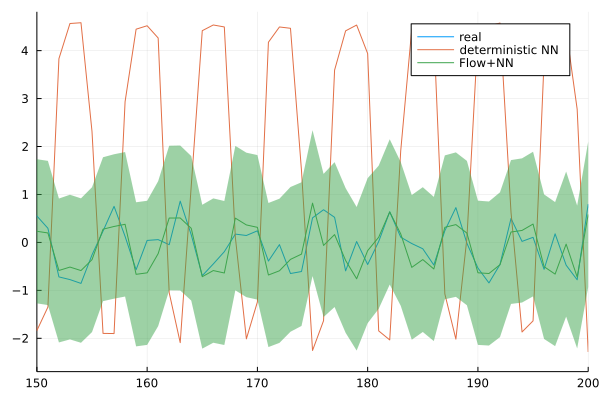

In [258]:
plot(Y_test, label="real")
plot!(n_output, label="deterministic NN")
plot!(mx, ribbon=sqrt.(vx), label="Flow+NN", xlims=(test_from, test_to))